# Word2Vec

In [1]:
import sys

In [2]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, texts_to_token_ids, \
    PaddedSequenceDataset, Embeddings
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

init_random_seed()

## Загрузка данных и подготовка корпуса

In [3]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
full_dataset = list(pd.read_csv('./nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

1/4 cup sour cream
10 ounces swordfish, red snapper or other firm-fleshed fish
1 tablespoon minced basil leaves
Handful fresh parsley, finely minced
4 ounces lard or butter, plus more for brushing tops
4 to 5 green cardamom pods
1 stick ( 1/4 pound) unsalted butter, softened
1/4 teaspoon red pepper flakes, preferably Turkish or Aleppo (see note), more to taste
1 tablespoon fresh lemon juice
1/4 cup scallions, thinly sliced


In [4]:
# токенизируем
train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

sour cream
ounces swordfish snapper other firm fleshed fish
tablespoon minced basil leaves
handful fresh parsley finely minced
ounces lard butter plus more brushing tops
green cardamom pods
stick pound unsalted butter softened
teaspoon pepper flakes preferably turkish aleppo note more taste
tablespoon fresh lemon juice
scallions thinly sliced


In [5]:
# строим словарь
# добавим фиктивный токен в словарь: "токена выравнивания" - '<PAD>'. Это нужно для  объединения предложений разной длины в прямоугольный тензор.
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2267
[('<PAD>', 0), ('tablespoons', 1), ('teaspoon', 2), ('chopped', 3), ('salt', 4), ('pepper', 5), ('cups', 6), ('ground', 7), ('fresh', 8), ('tablespoon', 9)]


In [6]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

222 52
22 878 574 127 246 707 181
9 19 88 33
517 8 43 15 19
22 586 20 45 47 648 649
59 329 535
200 12 50 20 266
2 5 140 78 1208 735 153 47 10
9 8 31 25
98 65 27


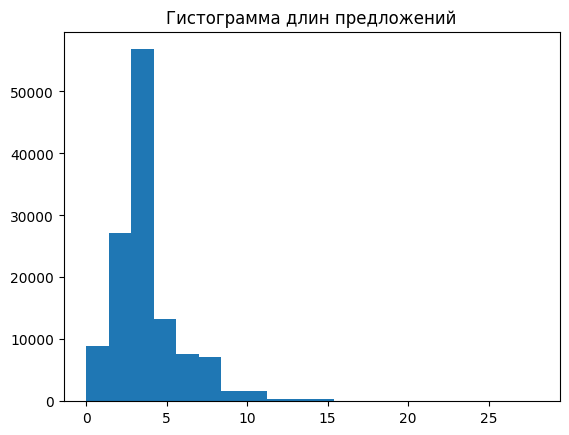

In [7]:
# Для того что бы выбрать длину эмбединга
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');
# Видим, что длина предложения в большинстве случаев < 20 токенов => MAX_SENTENCE_LEN = 20 выбираем

In [8]:
MAX_SENTENCE_LEN = 20
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([222,  52,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


## Алгоритм обучения - Skip Gram Negative Sampling

**Skip Gram** - предсказываем соседние слова по центральному слову

**Negative Sampling** - аппроксимация softmax

$$ W, D \in \mathbb{R}^{Vocab \times EmbSize} $$

$$ \sum_{CenterW_i} P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) \rightarrow \max_{W,D} $$

$$ P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) = \prod_j P(CtxW_j | CenterW_i; W, D) $$
    
$$ P(CtxW_j | CenterW_i; W, D) = \frac{e^{w_i \cdot d_j}} { \sum_{j=1}^{|V|} e^{w_i \cdot d_j}} = softmax \simeq \frac{e^{w_i \cdot d_j^+}} { \sum_{j=1}^{k} e^{w_i \cdot d_j^-}}, \quad k \ll |V| $$

In [9]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

**Negative Sampling** работает следующим образом - мы **максимизируем сумму вероятностей двух событий**:

* "этот пример центрального слова вместе с контекстными словами взят **из тренировочной выборки**": $$ P(y=1 | CenterW_i; CtxW_j) = sigmoid(w_i \cdot d_j) = \frac{1}{1+e^{-w_i \cdot d_j}} $$

$$ \\ $$

* "этот пример центрального слова вместе со случайми контекстными словами **выдуман** ": $$ P(y=0 | CenterW_i; CtxW_{noise}) = 1 - P(y=1 | CenterW_i;  CtxW_{noise}) = \frac{1}{1+e^{w_i \cdot d_{noise}}} $$

$$ \\ $$

$$ NEG(CtxW_j, CenterW_i) = log(\frac{1}{1+e^{-w_i \cdot d_j}}) + \sum_{l=1}^{k}log(\frac{1}{1+e^{w_i \cdot d_{noise_l}}})  \rightarrow \max_{W,D} $$

In [10]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0) # Матрица W; nn.Embedding - реализует ф-ции выбора из таблицы W по номеру токена
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size) # Правильное начальное заполнение таблицы W
        self.center_emb.weight.data[0] = 0 # Для токена с номером ноль не надо учить вектор! Для него вектор всегда будет нулевым

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0) # Матрица D
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)

    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength Матрица оценки сходства двух токенов в предложении
        positive_probs = torch.sigmoid(positive_sims) # Оценка вероятности для всех возможных пар токенов в предложении

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask, # Накладываем маску на вероятности встретить пары токенов в предложении
                                               positive_mask.expand_as(positive_probs)) # Настоящая метка для таких событий = большой вероятности (близкой к 1)

        # выбрать случайные "отрицательные" слова. torch.randint --- получить номера токенов, которые мы будем использовать как отрицательные
        negative_words = torch.randint(1, self.vocab_size, # В качестве негативных примеров мы выбираем случайные слова. Здесь использовано равномерное семплирование, но вообще говоря нужно использовать не равномерное: более часто используются редкие слова
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN. Для полученых номеров отрицательных токенов делаем выборку из контекстных векторов и транспонируем её
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN

        # уменьшить оценку вероятность встретить эти пары слов вместе. "_with_logits" --- более стабильный способ (предварительно не нормируем)
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape)) # Передаем нули как таргеты

        return positive_loss + negative_loss # Значение ф-ции потерь для положительных и отрицательных примеров


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

## Обучение

In [11]:
# radius --- ширина окна;
# egative_samples_n --- число отрицательных токенов, которые мы будем семплировать для каждого предложения
trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=25)

In [12]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=2,
                                            batch_size=8,
                                            device='cpu',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2001 итераций, 8.15 сек
Среднее значение функции потерь на обучении 0.888857262990047
Среднее значение функции потерь на валидации 0.880995516766387
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 10.02 сек
Среднее значение функции потерь на обучении 0.8782672056968304
Среднее значение функции потерь на валидации 0.8773917544536065
Новая лучшая модель!



In [13]:
# Сохранение модели
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(trainer.state_dict(), './models/sgns.pth')

In [14]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
trainer.load_state_dict(torch.load('./models/sgns.pth'))

<All keys matched successfully>

## Исследуем характеристики полученных векторов

In [15]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [16]:
embeddings.most_similar('chicken')

[('chicken', 0.9999383),
 ('duck', 0.628107),
 ('thighs', 0.5987907),
 ('breasts', 0.5920699),
 ('stock', 0.57445955),
 ('broth', 0.55016077),
 ('quarts', 0.53687507),
 ('breast', 0.5306596),
 ('sodium', 0.5203186),
 ('apart', 0.509841)]

In [17]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('emmenthal', 1.0508474),
 ('cheeses', 1.0136814),
 ('gorgonzola', 0.9944502),
 ('cheese', 0.9929821),
 ('cottage', 0.98830247),
 ('glaze', 0.9823799),
 ('sheep', 0.97276324),
 ('cacao', 0.9689916),
 ('monterey', 0.96777874),
 ('gruyère', 0.96404415)]

In [18]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


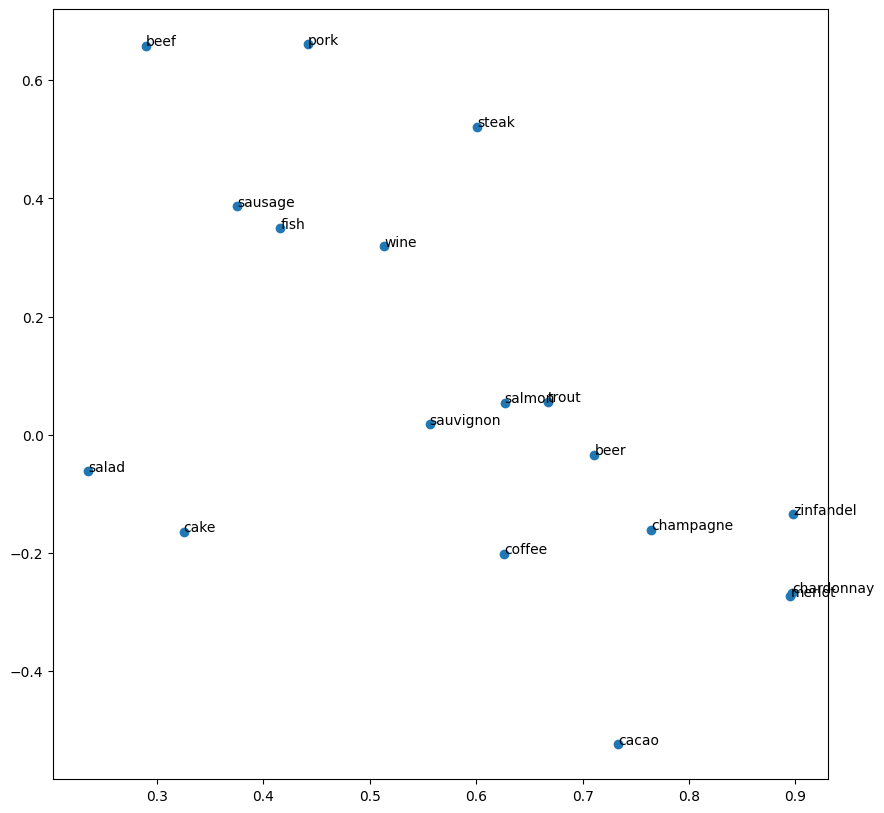

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Обучение Word2Vec с помощью Gensim

In [20]:
import gensim

In [21]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, vector_size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, epochs=10)

In [22]:
word2vec.wv.most_similar('chicken')

[('pheasant', 0.7023141980171204),
 ('duck', 0.7013475894927979),
 ('simmering', 0.6955505013465881),
 ('thighs', 0.6896621584892273),
 ('turkey', 0.6724847555160522),
 ('drumsticks', 0.6668494939804077),
 ('squab', 0.6589784622192383),
 ('wings', 0.6544864773750305),
 ('rabbit', 0.6510558724403381),
 ('breasts', 0.6481972932815552)]

In [23]:
gensim_words = [w for w in test_words if w in word2vec.wv.key_to_index]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

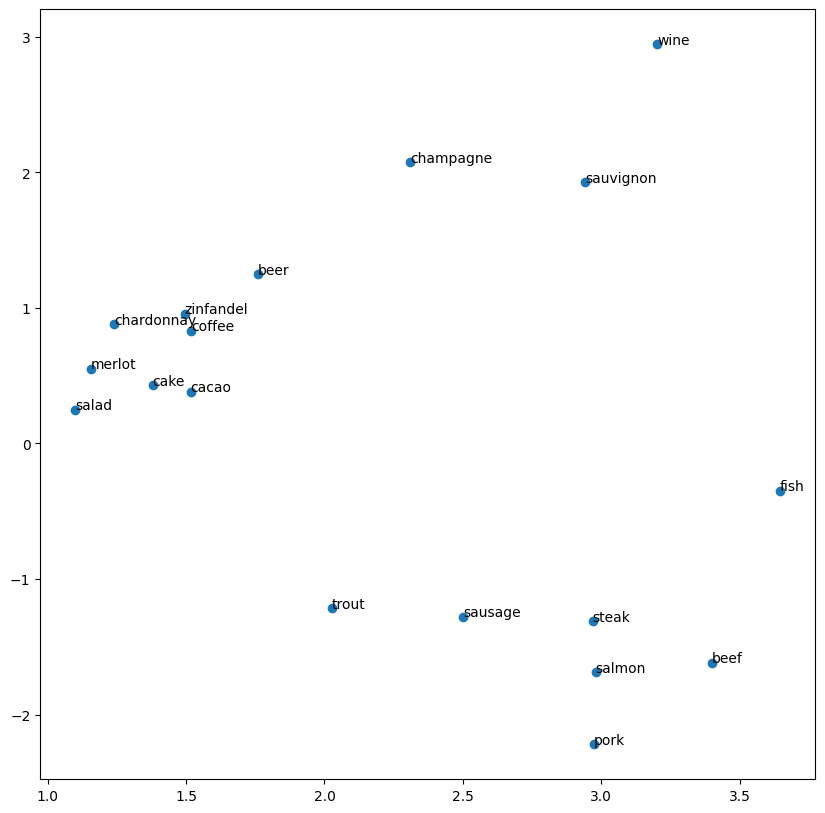

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [25]:
import gensim.downloader as api

In [26]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [27]:
pretrained = api.load('word2vec-google-news-300')  # > 1.5 GB!

In [28]:
pretrained.most_similar('cheese')

[('cheeses', 0.7788999676704407),
 ('cheddar', 0.7627597451210022),
 ('goat_cheese', 0.7297402024269104),
 ('Cheese', 0.7286962270736694),
 ('cheddar_cheese', 0.725513756275177),
 ('Cheddar_cheese', 0.6943709254264832),
 ('mozzarella', 0.6805710196495056),
 ('cheddar_cheeses', 0.6694672107696533),
 ('Camembert', 0.6623161435127258),
 ('gruyere', 0.6615148186683655)]

In [29]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

[('woman', 0.7609436511993408),
 ('girl', 0.6139993667602539),
 ('teenage_girl', 0.6040961742401123),
 ('teenager', 0.5825759172439575),
 ('lady', 0.5752554535865784),
 ('boy', 0.5077577233314514),
 ('policewoman', 0.5066847801208496),
 ('schoolgirl', 0.5052096247673035),
 ('blonde', 0.4869619309902191),
 ('person', 0.48637545108795166)]

In [30]:
pretrained_words = [w for w in test_words if w in pretrained.key_to_index]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

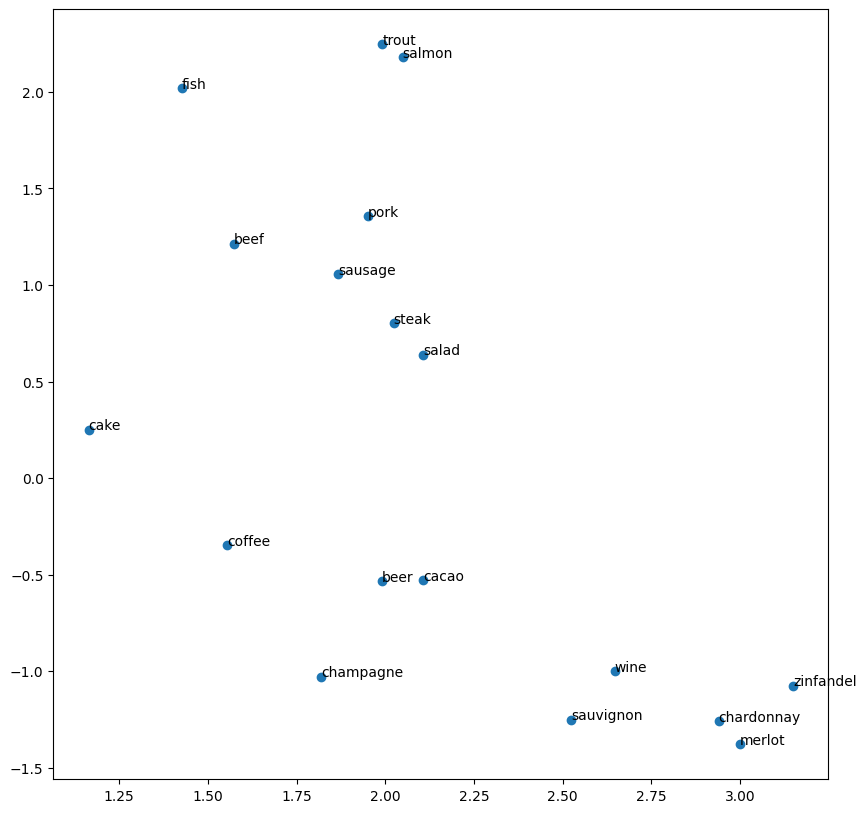

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение

* Реализовали Skip Gram Negative Sampling на PyTorch
* Обучили на корпусе рецептов
    * Сходство слов модель выучила неплохо
    * Для аналогий мало данных
* Обучили SGNS с помощью библиотеки Gensim
* Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)
    * Списки похожих слов отличаются!
    * Аналогии работают